In [1]:
from __future__ import division

import numpy as np
import threading
import seaborn
import timeit
import random
import dubins
import time
import math
import sys
import os

from numpy.linalg import inv
from scipy.integrate import ode
from scipy.optimize import minimize
from matplotlib import pyplot as plt

np.set_printoptions(precision=3,suppress=True)

%matplotlib inline

# RRT solver

In [2]:
def normalize_angle(theta):
    return math.atan2(math.sin(theta), math.cos(theta))

class Pose(object):
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = normalize_angle(theta)
    
    def as_tuple(self):
        return (self.x, self.y, self.theta)

class RRTPlanner(object):
    def __init__(self, sample_free, steer, drivable, distance, neigbourhood_size):
        self.sample_free = sample_free
        self.distance = distance
        self.drivable = drivable
        self.steer = steer
        
        self.neigbourhood_size = neigbourhood_size
    
        self.graph  = {}
        self.parent = {}
        self.cost   = {}
        self.failed_points = {}
        self.failed_rands = {}

    def add_first_node(self, point):
        self.graph[point] = []
        self.cost[point] = 0

    def step(self):
        x_rand = self.sample_free()
        x_nearest = self.nearest_neighbour(x_rand)

        x_new = self.steer(x_nearest, x_rand)

        if self.drivable(x_nearest, x_new):
            X_near = self.neighbourhood(x_new)

            x_min = x_nearest
            c_min = self.cost[x_nearest] + self.distance(x_nearest, x_new)

            for x_near in X_near:
                if self.drivable(x_near, x_new) and (self.cost[x_near] + self.distance(x_near, x_new) < c_min):
                    x_min = x_near
                    c_min = self.cost[x_near] + self.distance(x_near, x_new)

            self.add_node(x_min, x_new)

            for x_near in X_near:
                if self.drivable(x_new, x_near) and (self.cost[x_new] + self.distance(x_new, x_near) < self.cost[x_near]):
                    self.reparent(x_near, x_new)
        else:
            self.failed_points[x_new] = x_nearest
            self.failed_rands[x_new] = x_rand

    def nearest_neighbour(self, x_rand):
        min_dist = 100000

        closest = None

        for node in self.graph:
            dist = self.distance(node, x_rand)

            if dist < min_dist:
                min_dist = dist
                closest = node

        return closest

    def neighbourhood(self, x_rand):
        neighbourhood = []

        for node in self.graph:
            if self.distance(node, x_rand) <= self.neigbourhood_size:
                neighbourhood.append(node)

        return neighbourhood

    def add_node(self, start, end):
        self.graph[end] = []
        self.graph[start].append(end)
        self.parent[end] = start
        self.cost[end] = self.cost[start] + self.distance(start, end)
    
    def reparent(self, node, new_parent):
        self.graph[self.parent[node]].remove(node)
        
        self.parent[node] = new_parent
        self.graph[new_parent].append(node)
        self.cost[node] = self.cost[new_parent] + self.distance(new_parent, node)

    def path(self, current):
        path = [current]

        if current not in self.parent:
            next_currents = self.neighbourhood(current)
            
            best_current = None
            cost_current = 10000
    
            for next_current in next_currents:
                if self.drivable(next_current, current):
                    if self.cost[next_current] + self.distance(next_current, current) < cost_current:
                        best_current = next_current
                        cost_current = self.cost[next_current] + self.distance(next_current, current)

            if best_current:
                current = best_current
                
                path.append(current)
            else:
                return None
        
        while current in self.parent:        
            current = self.parent[current]

            path.append(current)

        return path

def sample():
    while True:
        sample_x = random.uniform(x_max, x_min)
        sample_y = random.uniform(y_max, y_min)
        
        theta = math.atan2(end.y - sample_y, end.x - sample_x)

        sample = Pose(sample_x, sample_y, theta + math.radians(45) * random.uniform(-1, 1))

        if drivable_point(sample):
            return sample

def steer(start, end):
    return end

    if euclidean_distance(start, end) < node_length:
        return end
    else:
        theta = math.atan2(end.x - start.x, end.y - start.y)
        x = start.x + node_length * math.cos(theta)
        y = start.y + node_length * math.sin(theta)
        return Pose(x, y, end.theta)

def drivable(start, end):
    qs, _ = dubins.path_sample(start.as_tuple(), end.as_tuple(), turning_radius, collision_step_size)

    for x, y, phi in qs:
        if not drivable_point(Pose(x, y, phi)):
            return False

    return True

def drivable_point(point):
    for obstacle in obstacles:
        r = (obstacle['center'][0] - point.x) ** 2 + \
            (obstacle['center'][1] - point.y) ** 2
        
        if r < obstacle['radius']:
            return False
    
    if point.x > x_max or point.x < x_min:
        return False
    
    if point.y > y_max or point.y < y_min:
        return False
    
    return True

def distance(p1, p2):
    return math.fabs(dubins.path_length(p1.as_tuple(), p2.as_tuple(), turning_radius))

def euclidean_distance(p1, p2):
    return math.sqrt(
        (p1.x - p2.x) ** 2 +
        (p1.y - p2.y) ** 2
    )

# Convex optimizer

In [3]:
def kinematics_constraints(j, dt=0.1):
    def _kinematics_fn(X):
        x,y,theta,xn,yn,thetan = X[3*j:3*j+6]
        v,w = X[3*N+2*j:3*N+2*j+2]
        out = [x + v*math.cos(theta)*dt-xn, y + v*math.sin(theta)*dt-yn, theta+w*dt-thetan]
        #print "out: ", j, "|", x,y,theta, xn,yn,thetan, ">", out
        return np.array(out)
    return _kinematics_fn

def kinematics_constraints_jac(j, dt=0.1):
    def _kinematics_jac(X):
        U = np.zeros((3, N * 5 - 2))

        x,y,theta,xn,yn,thetan = X[3*j:3*j+6]
        v,w = X[3*N+2*j:3*N+2*j+2]
        
        ix, iy, itheta, ixn, iyn, ithetan = range(3*j, 3*j + 6)
        iv, iw = range(3*N+2*j,3*N+2*j+2)

        U[0, ix] = 1
        U[0, iv] = math.cos(theta) * dt
        U[0, ixn] = -1
        U[0, itheta] = -v*dt*math.sin(theta)

        U[1, iy] = 1
        U[1, iv] = math.sin(theta) * dt
        U[1, iyn] = -1
        U[1, itheta] = v*dt*math.cos(theta)

        U[2, itheta] = 1
        U[2, iw] = dt
        U[2, ithetan] = -1

        return U
    return _kinematics_jac

def obstacle_constraint(p, q, r, j):
    def _obstacle(X):
        x, y = X[3*j:3*j+2]
        return (x - p) ** 2 + (y - q) ** 2 - r ** 2
    return _obstacle

def obstacle_constraint_jac(p, q, r, j):
    def _obstacle_jac(X):
        U = np.zeros(N * 5 - 2)
        
        U[3*j] = 2 * (X[3*j] - p)
        U[3*j + 1] = 2 * (X[3*j + 1] - q)

        return U

    return _obstacle_jac

def cost_fn(coeff):
    coeff = np.array(coeff)
    def _cost_fn(X):
        U = X[3*N:]
        return sum(coeff*U*U)
    return _cost_fn

def cost_fn_jacobian(coeff):
    coeff = np.array(coeff)

    def _cost_jac(X):
        U = np.zeros(N * 5 - 2)
        
        U[3*N:] = X[3*N:] * coeff * 2
        
        return U

    return _cost_jac

def simple_jacobian(variable, coeff):
    def _simple_jac(X):
        U = np.zeros(N * 5 - 2)
        
        U[variable] = coeff
        
        return U

    return _simple_jac

def solve_mpc(X0, Xgoal):
    cons = []

    for j in range(N-1):
        cons.append({'type':'eq', 'fun': kinematics_constraints(j), 'jac': kinematics_constraints_jac(j)})

    cons.append({'type':'eq', 'fun': lambda X: X[0],           'jac': simple_jacobian(0, 1)})
    cons.append({'type':'eq', 'fun': lambda X: X[1],           'jac': simple_jacobian(1, 1)})
    cons.append({'type':'eq', 'fun': lambda X: X[2]-math.pi/4, 'jac': simple_jacobian(2, 1)})

    cons.append({'type':'eq', 'fun': lambda X: X[3*N-3]-Xgoal[0], 'jac': simple_jacobian(3*N-3, 1)})
    cons.append({'type':'eq', 'fun': lambda X: X[3*N-2]-Xgoal[1], 'jac': simple_jacobian(3*N-2, 1)})
    cons.append({'type':'eq', 'fun': lambda X: X[3*N-1]-Xgoal[2], 'jac': simple_jacobian(3*N-1, 1)})

    for obstacle in obstacles:
        for j in range(N-1):
            obs = obstacle_constraint(obstacle['center'][0], obstacle['center'][1], obstacle['radius'], j)
            jac = obstacle_constraint_jac(obstacle['center'][0], obstacle['center'][1], obstacle['radius'], j)

            cons.append({'type':'ineq', 'fun': obs, 'jac': jac})

    all_xs = []

    r = minimize(
        cost_fn(coeff), 
        X0, 
        constraints=cons,
        jac=cost_fn_jacobian(coeff),
        options={'maxiter':100}, 
        callback=lambda a:all_xs.append(np.copy(a)))
    
    return r, all_xs

# RRT and convex optimizer parameters

In [4]:
turning_radius = 3
collision_step_size = 0.1

node_length = 5
neigbourhood_size = 10

N=20
coeff = [1] * (2*N-2)

In [5]:
x_max, x_min =  8, 0
y_max, y_min =  12, 0

obstacles = [
   {
       "center": [3, 4],
       "radius": 1.5,
   },
   {
       "center": [5, 8],
       "radius": 1.5,
   }
]

Xinit = [0,  0, math.pi/4]
Xgoal = [8, 12, math.pi/4]


# Run RRT and convex optimizer

In [6]:
random.seed()

# Start and end
start = Pose(*Xinit)
end =   Pose(*Xgoal)

planner = RRTPlanner(sample, steer, drivable, distance, neigbourhood_size)

planner.add_first_node(start)

t1 = timeit.default_timer()

for step in range(0, 1000):
    if step % 10 == 0 and planner.path(end):
        print "Step {}".format(step)

        break

    planner.step()

t2 = timeit.default_timer()

path = planner.path(end)
path.reverse()

print "{} ms".format((t2 - t1) * 1000)

Step 10
7.78198242188 ms


In [7]:
l = 0.

for fro, to in zip(path, path[1:]):
    l += dubins.path_length(fro.as_tuple(), to.as_tuple(), turning_radius)

stepsize = l / N
v = stepsize * 10

X0 = []
X0_end = []

last_q = None

for fro, to in zip(path, path[1:]):
    qs, _ = dubins.path_sample(fro.as_tuple(), to.as_tuple(), turning_radius, stepsize)
    
    if to != end:
        qs = qs[:-1]

    for q in qs:
        X0.append(q[0])
        X0.append(q[1])
        X0.append(q[2])

        if last_q:
            X0_end.append(v)
            X0_end.append(10 * (q[2] - last_q[2]))

        last_q = q

X0 += X0_end

In [8]:
t1 = timeit.default_timer()

solution, intermediate_solutions = solve_mpc(X0, Xgoal)

t2 = timeit.default_timer()

print "{} ms\n".format((t2 - t1) * 1000)

print solution

67.2860145569 ms

     fun: 1213.1181619198244
     jac: array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,  12.384,   6.733,  14.804,
         3.173,  15.378,   1.319,  15.503,   0.239,  15.519,  -0.697,
        15.467,  -2.049,  16.52 ,  -1.006,  16.531,  -0.538,  16.54 ,
        -0.436,  16.539,  -0.633,  16.523,  -1.263,  16.442,  -2.745,
        16.877,  -3.741,  15.684,  -1.696,  15.848,  -0.688,  15.882,
        -0.113,  15.886,   0.392,

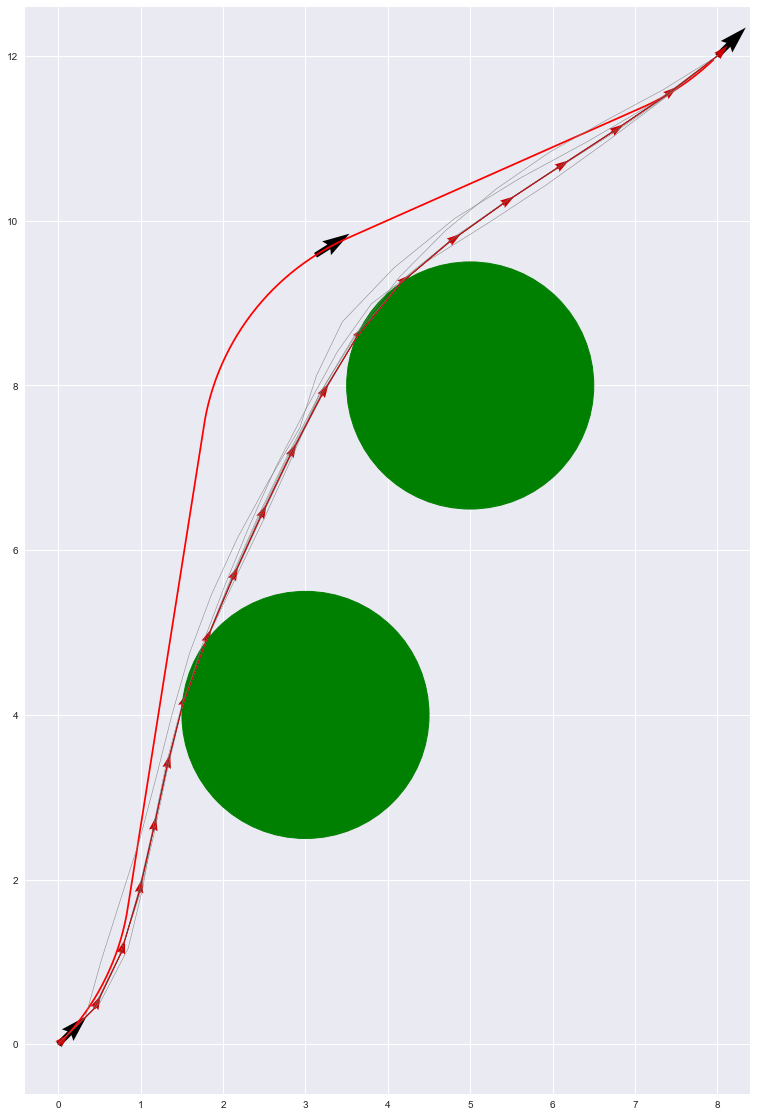

In [9]:
fig, ax = plt.subplots(1, figsize=(20, 20))

for obstacle in obstacles:
    ax.add_patch(plt.Circle(obstacle['center'], obstacle['radius'], linewidth=1, edgecolor='g', facecolor='g'))

ax.set_aspect('equal')

plt.quiver(
    [x.x for x in path],
    [x.y for x in path],
    [math.cos(x.theta) for x in path],
    [math.sin(x.theta) for x in path],
)

xs = []
ys = []

for fro, to in zip(path, path[1:]):
    qs, _ = dubins.path_sample(fro.as_tuple(), to.as_tuple(), turning_radius, 0.1)

    xs += [q[0] for q in qs]
    ys += [q[1] for q in qs]

plt.plot(xs, ys, color='r')

for xs in intermediate_solutions:
    x_y_phi_t = xs[0:3*N].reshape((N,3))
    plt.plot(x_y_phi_t[:, 0], x_y_phi_t[:, 1], color='0.5', linewidth=0.5)

x_y_phi = solution.x[0:3*N].reshape((N,3)) 
v_omega = solution.x[3*N:].reshape((N-1,2))

plt.quiver(x_y_phi[:, 0], x_y_phi[:, 1], np.cos(x_y_phi[:, 2]), np.sin(x_y_phi[:, 2]), scale=50, color='#cc0000', linewidth=1)
plt.plot(x_y_phi[:, 0], x_y_phi[:, 1], color='#cc0000', linewidth=1)

plt.show()

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(v_omega[:, 0], drawstyle='steps')
ax2.plot(v_omega[:, 1], drawstyle='steps')
plt.show()